In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
%matplotlib inline

pd.set_option("display.max_columns", 100)

# Predicting USA Election 2016

Let's see what we can predict about today's vote!

First, we need an overview of how the system works. Each state has a weighting which is based to some extent on its population size, this is called the Electoral College. There are 538 Electoral College votes in total, and whomever wins the popular vote in a state gets all the Electoral College votes for that state - with two exceptions, Maine and Nebraska. These two states have a Congressional District system that means that the winner of each Congressional District (2 for Maine and 3 for Nebraska) gets 1 vote for each and then 2 extra votes for whomever won the state overall (so 4 total Electoral College votes for Maine and 5 for Nebraska). Additionally Washington DC has 3 Electoral College votes though it is not a state. 

It takes 270 votes to win, and if any candidate fails to reach this then there would have to be a House of Representatives vote to decide with each state having one vote (this has happened three times: in 1800, 1824, and 1876). As you no doubt remember, this system means it is also possible to win having lost the nationwide popular vote as George W Bush did in 2000. We will hence go for a state by state model and not consider the nationwide popularity of each candidate.

In [2]:
# You can get some data on the electoral college votes here
# This gives a weighting to each state's popular vote

electoral_college=pd.read_csv("https://raw.githubusercontent.com/chris-taylor/USElection/master/data/electoral-college-votes.csv", header=None)
electoral_college.columns=["state", "electoral_votes"]

In [3]:
# You can get the latest polling data from 538 here

polling=pd.read_csv("http://projects.fivethirtyeight.com/general-model/president_general_polls_2016.csv")

In [4]:
# This polling data includes national polls but let's just look at the state data

polling2=polling.loc[~polling["state"].str.contains("U.S."),:]
polling2.tail()

,cycle,branch,type,matchup,forecastdate,state,startdate,enddate,pollster,grade,samplesize,population,poll_wt,rawpoll_clinton,rawpoll_trump,rawpoll_johnson,rawpoll_mcmullin,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,multiversions,url,poll_id,question_id,createddate,timestamp
12619,2016,President,polls-only,Clinton vs. Trump vs. Johnson,11/8/16,New Hampshire,7/9/2016,7/18/2016,University of New Hampshire,B+,469.0,lv,0.0,37.00,37.00,10.0,NaN,40.24983,43.04717,6.924110,NaN,NaN,https://cola.unh.edu/sites/cola.unh.edu/files/...,44650,68189,7/21/16,09:14:14 8 Nov 2016
12620,2016,President,polls-only,Clinton vs. Trump vs. Johnson,11/8/16,Wisconsin,10/21/2016,11/2/2016,Ipsos,A-,653.0,lv,0.0,47.48,38.96,NaN,NaN,46.54218,38.96884,NaN,NaN,NaN,http://www.reuters.com/statesofthenation/,48259,75560,11/3/16,09:14:14 8 Nov 2016
12621,2016,President,polls-only,Clinton vs. Trump vs. Johnson,11/8/16,New York,8/7/2016,8/10/2016,Siena College,A,717.0,rv,0.0,50.00,25.00,9.0,NaN,53.83622,32.47939,3.881193,NaN,NaN,https://www.siena.edu/assets/files/news/SNY081...,44852,68743,8/15/16,09:14:14 8 Nov 2016
12622,2016,President,polls-only,Clinton vs. Trump vs. Johnson,11/8/16,Virginia,9/30/2016,10/6/2016,Ipsos,A-,479.0,lv,0.0,50.49,39.05,NaN,NaN,49.57558,39.96954,NaN,NaN,NaN,http://www.reuters.com/statesofthenation/,46675,72969,10/10/16,09:14:14 8 Nov 2016
12623,2016,President,polls-only,Clinton vs. Trump vs. Johnson,11/8/16,Wisconsin,6/9/2016,6/12/2016,Marquette University,A,666.0,lv,0.0,46.00,37.00,NaN,NaN,46.40999,39.19839,NaN,NaN,NaN,https://law.marquette.edu/poll/2016/06/15/new-...,44341,66966,6/15/16,09:14:14 8 Nov 2016


In [5]:
# Let's just look at the most recent poll for each state (this is something you want to look more into)

polling2=polling2.sort_values(by=["state", "enddate"], ascending=False)
polling3=polling2.drop_duplicates(subset="state")
polling3

,cycle,branch,type,matchup,forecastdate,state,startdate,enddate,pollster,grade,samplesize,population,poll_wt,rawpoll_clinton,rawpoll_trump,rawpoll_johnson,rawpoll_mcmullin,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,multiversions,url,poll_id,question_id,createddate,timestamp
2676,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,Wyoming,8/31/2016,9/6/2016,Google Consumer Surveys,B,69.0,lv,0.001821,22.38,46.76,9.73,NaN,30.32889,56.01622,5.443565,NaN,NaN,https://drive.google.com/drive/u/0/folders/0B2...,45489,70807,9/9/16,09:35:33 8 Nov 2016
2916,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,Wisconsin,8/26/2016,9/8/2016,Ipsos,A-,523.0,lv,0.000830,38.43,39.67,NaN,NaN,38.58803,40.74298,NaN,NaN,NaN,http://www.reuters.com/statesofthenation/,45683,71252,9/10/16,09:35:33 8 Nov 2016
2740,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,West Virginia,8/19/2016,9/8/2016,Ipsos,A-,137.0,lv,0.001473,39.41,54.04,NaN,NaN,39.44972,55.14646,NaN,NaN,NaN,http://www.reuters.com/statesofthenation/,45682,71251,9/10/16,09:35:33 8 Nov 2016
2854,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,Washington,8/26/2016,9/8/2016,Ipsos,A-,502.0,lv,0.001009,45.05,37.02,NaN,NaN,45.09700,38.02834,NaN,NaN,NaN,http://www.reuters.com/statesofthenation/,45681,71250,9/10/16,09:35:33 8 Nov 2016
2748,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,Virginia,8/26/2016,9/8/2016,Ipsos,A-,743.0,lv,0.001442,50.38,37.08,NaN,NaN,50.40878,37.95112,NaN,NaN,NaN,http://www.reuters.com/statesofthenation/,45680,71249,9/10/16,09:35:33 8 Nov 2016
2726,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,Vermont,8/31/2016,9/6/2016,Google Consumer Surveys,B,66.0,lv,0.001549,43.01,12.63,12.97,NaN,51.23601,22.26286,8.683566,NaN,NaN,https://drive.google.com/drive/u/0/folders/0B2...,45485,70803,9/9/16,09:35:33 8 Nov 2016
1793,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,Utah,9/1/2016,9/9/2016,Dan Jones & Associates,C+,605.0,lv,0.015088,24.00,39.00,13.00,9.0,25.86517,41.60105,8.599159,11.02832,NaN,http://utahpolicy.com/index.php/features/today...,45706,71311,9/12/16,09:35:33 8 Nov 2016
2965,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,Texas,9/2/2016,9/8/2016,Ipsos,A-,405.0,lv,0.000696,30.91,48.29,NaN,NaN,30.86591,49.01034,NaN,NaN,NaN,http://www.reuters.com/statesofthenation/,45678,71247,9/10/16,09:35:33 8 Nov 2016
2858,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,Tennessee,8/26/2016,9/8/2016,Ipsos,A-,413.0,lv,0.000988,27.91,48.53,NaN,NaN,28.17780,49.64547,NaN,NaN,NaN,http://www.reuters.com/statesofthenation/,45677,71246,9/10/16,09:35:33 8 Nov 2016
2860,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,South Dakota,8/31/2016,9/6/2016,Google Consumer Surveys,B,59.0,lv,0.000979,35.35,34.63,5.52,NaN,43.30567,43.89544,1.233565,NaN,NaN,https://drive.google.com/drive/u/0/folders/0B2...,45480,70798,9/9/16,09:35:33 8 Nov 2016


In [6]:
# Perform a Monte Carlo simulation for eg 1000 elections in each state, where I have set a normal distribution
# on the polling numbers (which are in percentages) with a mean of the poll results and a 
# fixed standard deviation on every poll (so a number I just made up - you will want to look more 
# into this to see if you can vary it by state, perhaps based on an historical analysis of polls in the dataset)

random_seeds=uniform.rvs(loc=0, scale=1000, size=100, random_state=538).astype(int)
results_total=pd.DataFrame(columns=["simulation_number","clinton_results", "trump_results", "state"])
i=0
for index,row in polling3.iterrows():
    # Simulate Clinton
    clinton_prob=row["rawpoll_clinton"]
    mean_clinton, std_clinton = clinton_prob, 5
    results_clinton=norm.rvs(mean_clinton, std_clinton, 1000, random_state=random_seeds[i])
    results_clinton_df=pd.DataFrame(results_clinton).reset_index()
    results_clinton_df.columns=["simulation_number", "clinton_results"]
    # Simulate Trump
    trump_prob=row["rawpoll_trump"]
    mean_trump, std_trump = trump_prob, 5
    results_trump=norm.rvs(mean_trump, std_trump, 1000, random_state=random_seeds[i+1])    
    results_trump_df=pd.DataFrame(results_trump).reset_index()
    results_trump_df.columns=["simulation_number", "trump_results"]
    # Put them together
    results_both=pd.merge(results_clinton_df, results_trump_df, on="simulation_number")
    results_both["state"]=row["state"]
    results_total=pd.concat([results_total, results_both], ignore_index=True)
    i=i+1

In [7]:
# This calculates who won which state under the simulations, and then how many electoral college votes
# that implies will go to the winner for that particular simulation

results_total["winner"]=np.nan
results_total["winner"]=np.where(results_total["clinton_results"]>results_total["trump_results"], "Clinton", "Trump")
results_total2=pd.merge(results_total, electoral_college, on="state", how="left")
results_total2["trump_ec"]=np.where(results_total2["winner"]=="Trump", results_total2["electoral_votes"], 0)
results_total2["clinton_ec"]=np.where(results_total2["winner"]=="Clinton", results_total2["electoral_votes"], 0)

In [8]:
# Calculates how many electoral college votes each candidate wins for each of the simulations

trump_electoral_votes=results_total2.groupby(["simulation_number"])["trump_ec"].sum().reset_index()
clinton_electoral_votes=results_total2.groupby(["simulation_number"])["clinton_ec"].sum().reset_index()
total_electoral_votes=pd.merge(trump_electoral_votes, clinton_electoral_votes, on="simulation_number")

In [9]:
# Returns the percentage probability for each candidate to win based on how many of the simulations they won

total_electoral_votes["winner"]=np.where(total_electoral_votes["clinton_ec"]>total_electoral_votes["trump_ec"], "Clinton", "Trump")
total_electoral_votes["winner"].value_counts(normalize=True)

Clinton    0.896
Trump      0.104
Name: winner, dtype: float64

Check these to see how your prediction compares!

- [538](http://projects.fivethirtyeight.com/2016-election-forecast)
- [NY Times](http://www.nytimes.com/interactive/2016/upshot/presidential-polls-forecast.html)
- [Washington Post](https://www.washingtonpost.com/2016-election-results/us-presidential-race/)
- [BuzzFeed](https://www.buzzfeed.com/franciswhittaker/make-america-goat-again?bffbuknews&utm_term=.pfp1mWrlX#.sueExwGR6)

Some things about this prediction which you could aim to improve:
- I only looked at the most recent poll for each state
- I assumed a fixed standard deviation for each state and for each candidate, with no justification, and no consideration of historical trends
- I did not consider the quality of the poll, whether in terms of the number of people polled or the reputation of the pollster
- I did not consider third party candidates (Gary Johnson is the Libertarian candidate, and Jill Stein is the Green candidate)
- I forgot to deal with Nebraska and Maine!
- I didn't deal with ties, strictly you need 270 votes to win
- I didn't explore extra terms from 538 in their table, such as what type of poll it is and what the adjusted poll
numbers mean (take a look at the 538 website to see what they have on this)

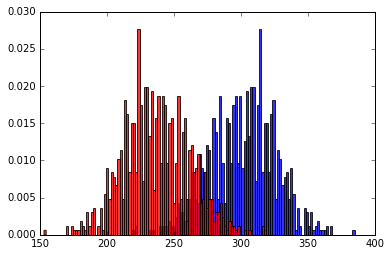

In [10]:
# Plot to show the distribution of total electoral college votes in the simulations

plt.hist(total_electoral_votes["clinton_ec"], color="blue", normed=True, bins=100, alpha=0.8)
plt.hist(total_electoral_votes["trump_ec"], color="red", normed=True, bins=100, alpha=0.8)
plt.show()

Bonus! You can visualise the results on a map in python. Maps tend to be pretty awkward in python which is why we tend to use Tableau, but I've done most of it for you here so you can focus on the fun. There is a topo-JSON file in the repo you can read in to map US states. You just need to `conda install vincent` in your terminal.

In [12]:
# Just going to visualise one simulation picked at random

state_data=results_total2.loc[results_total2["simulation_number"]==0,:]
state_data=state_data[["state", "winner"]]
mapping={"Clinton":1, "Trump":0}
state_data["winner"]=state_data["winner"].map(mapping)

In [15]:
state_data.head()

,state,winner
0,Wyoming,0
1000,Wisconsin,0
2000,West Virginia,0
3000,Washington,1
4000,Virginia,1


In [13]:
# This is a library which can do some mapping quite nicely, though
# it doesn't seem to be well maintained and doesn't have particularly good documentation
# conda install vincent to get it

import vincent
vincent.initialize_notebook()

We read in a local file we have on US states and we set the map up to read the winner column against the
state name (which it can understand directly). I set the color scheme up to show Red and Blue.
It's interesting that so many states can be red and still the blues win, that's down to the electoral colleges.
Try seeing what you can map, eg the most common scenarios or some kind of average and perhaps you can show gradients
of colours depending on how likely a state is to be won by a party. This way you can highlight swing states like Florida and in the end you can make your most likely prediction and see what the results are. 

So your output should be:
- an overall victor
- a number of electoral college votes
- a set of states with victors for each state

Organised as you like: just a prediction (i.e. most likely outcome), or a percentage likelihood, or some different scenarios. Point is just that you have those predictions to compare to the real results when they come out some time on Wednesday morning!

In [18]:
state_topo="us_states.topo.json"
geo_data = [{'name': 'states','url': state_topo,'feature': 'us_states.geo'}]

vis = vincent.Map(data=state_data, geo_data=geo_data, scale=1100, data_bind='winner', data_key='state', 
                  map_key={'states': 'properties.NAME'}, projection='albersUsa')
vis.scales['color'].type = 'threshold'
#vis.scales['color'].domain=[0,1]
vis.rebind(column='winner', brew='YlGnBu')
vis.display()

In [69]:
# Please make sure whatever you end up with for your model, you output your predictions to a csv before the results

In [140]:
# Don't take the latest but the most reliable
polling4= polling2[(polling2['grade']=="A+") | (polling2['grade']== "A")]
polling4=polling4.sort_values(by=["state", "grade","enddate"], ascending=False)
polling3=polling4.drop_duplicates(subset="state")
polling3.head()

,cycle,branch,type,matchup,forecastdate,state,startdate,enddate,pollster,grade,samplesize,population,poll_wt,rawpoll_clinton,rawpoll_trump,rawpoll_johnson,rawpoll_mcmullin,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,multiversions,url,poll_id,question_id,createddate,timestamp
987,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,Wisconsin,8/27/2016,8/30/2016,Monmouth University,A+,404.0,lv,0.113063,43.0,38.0,7.0,NaN,44.60706,41.28794,3.729785,NaN,NaN,http://www.monmouth.edu/polling-institute/repo...,45244,69555,8/31/16,05:11:53 8 Nov 2016
1423,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,Washington,8/9/2016,8/13/2016,Elway Research,A+,350.0,lv,0.030909,45.0,24.0,NaN,NaN,45.02700,28.36330,NaN,NaN,NaN,https://www.documentcloud.org/documents/301324...,44856,68751,8/15/16,05:11:53 8 Nov 2016
1393,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,Virginia,8/11/2016,8/14/2016,ABC News/Washington Post,A+,707.0,lv,0.033767,46.0,39.0,9.0,NaN,46.10411,42.30725,5.672546,NaN,NaN,http://apps.washingtonpost.com/g/page/politics...,44860,68760,8/16/16,05:11:53 8 Nov 2016
190,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,Utah,10/30/2016,11/2/2016,Monmouth University,A+,402.0,lv,1.874386,31.0,37.0,4.0,24.0,30.07987,36.66988,4.567851,24.10142,NaN,https://www.monmouth.edu/polling-institute/rep...,48191,75470,11/3/16,05:11:53 8 Nov 2016
3482,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,Texas,2/21/2016,2/22/2016,SurveyUSA,A,1289.0,lv,0.000075,44.0,47.0,NaN,NaN,40.70042,46.51358,NaN,NaN,NaN,http://www.surveyusa.com/client/PollReport.asp...,36436,66118,6/2/16,05:11:53 8 Nov 2016


In [149]:
# Measure the standard deviation per state

polling5 = polling4.pivot_table(index="state",values=["adjpoll_clinton","adjpoll_trump"],aggfunc=np.std)
polling5.head()

,adjpoll_clinton,adjpoll_trump
state,,
Arizona,2.207323,2.915517
California,2.816338,3.335233
Colorado,3.619870,2.477043
Delaware,0.737800,0.725603
Florida,2.315205,1.668718


In [150]:
# Same simulation as above but using the standard deviation from various polls, not always 5

# Perform a Monte Carlo simulation for eg 1000 elections in each state, where I have set a normal distribution
# on the polling numbers (which are in percentages) with a mean of the poll results and a 
# fixed standard deviation on every poll (so a number I just made up - you will want to look more 
# into this to see if you can vary it by state, perhaps based on an historical analysis of polls in the dataset)

random_seeds=uniform.rvs(loc=0, scale=1000, size=100, random_state=530).astype(int)
results_total=pd.DataFrame(columns=["simulation_number","clinton_results", "trump_results", "state"])
i=0
for index,row in polling3.iterrows():
    state = row['state']
    #print(state)
    # Simulate Clinton
    clinton_prob=row["rawpoll_clinton"]
    std_clinton = polling5['adjpoll_clinton'][state]
    mean_clinton = clinton_prob
    results_clinton=norm.rvs(mean_clinton, std_clinton, 1000, random_state=random_seeds[i])
    results_clinton_df=pd.DataFrame(results_clinton).reset_index()
    results_clinton_df.columns=["simulation_number", "clinton_results"]
    # Simulate Trump
    trump_prob=row["rawpoll_trump"]
    std_trump = polling5['adjpoll_trump'][state]
    mean_trump = trump_prob
    results_trump=norm.rvs(mean_trump, std_trump, 1000, random_state=random_seeds[i+1])    
    results_trump_df=pd.DataFrame(results_trump).reset_index()
    results_trump_df.columns=["simulation_number", "trump_results"]
    # Put them together
    results_both=pd.merge(results_clinton_df, results_trump_df, on="simulation_number")
    results_both["state"]=row["state"]
    results_total=pd.concat([results_total, results_both], ignore_index=True)
    i=i+1

In [151]:
# This calculates who won which state under the simulations, and then how many electoral college votes
# that implies will go to the winner for that particular simulation

results_total["winner"]=np.nan
results_total["winner"]=np.where(results_total["clinton_results"]>results_total["trump_results"], "Clinton", "Trump")
results_total2=pd.merge(results_total, electoral_college, on="state", how="left")
results_total2["trump_ec"]=np.where(results_total2["winner"]=="Trump", results_total2["electoral_votes"], 0)
results_total2["clinton_ec"]=np.where(results_total2["winner"]=="Clinton", results_total2["electoral_votes"], 0)

In [152]:
# Calculates how many electoral college votes each candidate wins for each of the simulations

trump_electoral_votes=results_total2.groupby(["simulation_number"])["trump_ec"].sum().reset_index()
clinton_electoral_votes=results_total2.groupby(["simulation_number"])["clinton_ec"].sum().reset_index()
total_electoral_votes=pd.merge(trump_electoral_votes, clinton_electoral_votes, on="simulation_number")

In [153]:
# Returns the percentage probability for each candidate to win based on how many of the simulations they won

total_electoral_votes["winner"]=np.where(total_electoral_votes["clinton_ec"]>total_electoral_votes["trump_ec"], "Clinton", "Trump")
total_electoral_votes["winner"].value_counts(normalize=True)

Clinton    1.0
Name: winner, dtype: float64

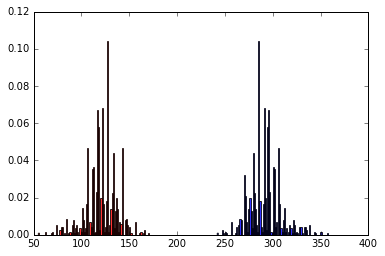

In [154]:
# Plot to show the distribution of total electoral college votes in the simulations

plt.hist(total_electoral_votes["clinton_ec"], color="blue", normed=True, bins=100, alpha=0.8)
plt.hist(total_electoral_votes["trump_ec"], color="red", normed=True, bins=100, alpha=0.8)
plt.show()

In [155]:
np.mean(total_electoral_votes["clinton_ec"])

291.842

In [156]:
np.mean(total_electoral_votes["trump_ec"])

121.158